<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM encoder-decoder

### 1 - Datos
El objecto es utilizar una serie de sucuencias númericas (datos sintéticos) para poner a prueba el uso de las redes LSTM. Este ejemplo se inspiró en otro artículo, lo tienen como referencia en el siguiente link:\
[LINK](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras-part-2/)

In [35]:
import re

import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [36]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [38]:
def to_categorical(y, num_classes=None, dtype='float32'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

### 1 - Datos

In [39]:
# Generar datos sintéticos
X = list()
y = list()

# En ambos casos "X" e "y" son vectores de números de 5 en 5
X = [x for x in range(5, 301, 5)]
y = [x+15 for x in X]

print(f"datos X (len={len(X)}):", X)
print(f"datos y (len={len(y)}):", y)

datos X (len=60): [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300]
datos y (len=60): [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315]


In [40]:
# Se desea agrupar los datos de a 3 elementos
X = np.array(X).reshape(len(X)//3, 3, 1)
y = np.array(y).reshape(len(y)//3, 3, 1)
print("datos X[0:2]:", X[0:2])
print("datos y[0:2]:", y[0:2])

datos X[0:2]: [[[ 5]
  [10]
  [15]]

 [[20]
  [25]
  [30]]]
datos y[0:2]: [[[20]
  [25]
  [30]]

 [[35]
  [40]
  [45]]]


In [41]:
# Verificamos que la secuencia enetrada es igual a la secuencia de salida
# en cuanto a dimensiones
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (20, 3, 1)
y shape: (20, 3, 1)


### 2 - Preprocesamiento

In [42]:
from sklearn import preprocessing

# Preparar datos para consumir por la layers LSTM
# Primero se toman todos los valores posibles que pueden tomar X e Y
# Con eso se genera un LabelEncoder para transformar de 0 - n_features
# Por cada dato de X e Y se genera su contraparte oneHotEncoding
# X1 equivale a X, es la secuencia de entrada
# X2 equivale a y sin el ultimo elemento, equivale a la secuenca "estado anterior"
# target equivale a Y como OneHotEncoding, la prediccion completa con el ultimo elemento

def get_dataset(X, Y, label_encoder=None):
    data = np.append(X, Y)
    labels = np.unique(data)

    if label_encoder is None:
        label_encoder = preprocessing.LabelEncoder()
        label_encoder.fit(labels)

    cardinality = len(label_encoder.classes_)
    print("Number of features/cardinality:", cardinality)

    X1, X2, target = list(), list(), list()
    for x, y in zip(X, Y):
        input = list(label_encoder.transform(x.reshape(-1)))
        output = list(label_encoder.transform(y.reshape(-1)))
        # Crear la entrada del "ultimo estado" de salida
        # que es la salida sin el ultimo elemento, que es el que el modelo
        # debe predecir
        output_in = [0] + output[:-1]

        # transformar
        input_encoded = to_categorical(input, num_classes=cardinality, dtype="int32")
        output_encoded = to_categorical(output, num_classes=cardinality, dtype="int32")
        output_in_encoded = to_categorical(output_in, num_classes=cardinality, dtype="int32")
       
        # almacenar
        X1.append(input_encoded)
        X2.append(output_in_encoded)
        target.append(output_encoded)
    return np.array(X1), np.array(X2), np.array(target), label_encoder

In [43]:
X1, X2, target, label_encoder = get_dataset(X, y)

Number of features/cardinality: 63


In [44]:
class Data(Dataset):
    def __init__(self, encoder_inputs, decoder_inputs, decoder_outputs):
        self.encoder_inputs = torch.from_numpy(encoder_inputs.astype(np.int32)).float()
        self.decoder_inputs = torch.from_numpy(decoder_inputs.astype(np.int32)).float()
        self.decoder_outputs = torch.from_numpy(decoder_outputs.astype(np.int32)).float()

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(X1, X2, target)

# El vector de salida tiene 3 dimensiones:
# primera dimension es la cantidad de "rows" del dataset
# segunda dimension es el tamaño de la sequencia de entrada/salida
# tercera dimensión es la dimensionalidad del vector oneHotEncoding (cardinality)
print("X1 shape:", X1.shape)
print("X2 shape:", X2.shape)
print("target shape:", target.shape)

encoder_input_size = data_set.encoder_inputs.shape[-1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[-1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[-1]
print("Output dim", output_dim)

X1 shape: (20, 3, 63)
X2 shape: (20, 3, 63)
target shape: (20, 3, 63)
encoder_input_size: 63
decoder_input_size: 63
Output dim 63


In [45]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 16
Tamaño del conjunto de validacion: 4


### 3 - Entrenar el modelo

In [46]:
class Encoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 1

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        lstm_output, (ht, ct) = self.lstm(x)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 1
        self.output_dim = output_dim

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        lstm_output, (ht, ct) = self.lstm(x, prev_state)
        out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)
        
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
      
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random 
            # para ver en cada vuelta que técnica se aplica
            #input = top1            

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs

encoder = Encoder(input_dim=encoder_input_size)
# decoder --> input_dim == output_dim --> porque recibe y devuelve en el mismo vocabulario
decoder = Decoder(input_dim=decoder_input_size, output_dim=output_dim)

model = Seq2Seq(encoder, decoder)

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = torch.nn.MSELoss()  # Para clasificación multi categórica
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model, input_data=(data_set[0:1][0], data_set[0:1][1]))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 3, 63]                --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─LSTM: 2-1                         [1, 3, 128]               98,816
├─Decoder: 1-2                           [1, 63]                   --
│    └─LSTM: 2-2                         [1, 1, 128]               98,816
│    └─Linear: 2-3                       [1, 63]                   8,127
│    └─Softmax: 2-4                      [1, 63]                   --
├─Decoder: 1-3                           [1, 63]                   (recursive)
│    └─LSTM: 2-5                         [1, 1, 128]               (recursive)
│    └─Linear: 2-6                       [1, 63]                   (recursive)
│    └─Softmax: 2-7                      [1, 63]                   --
├─Decoder: 1-4                           [1, 63]                   (recursive)
│    └─LSTM: 2-8                      

In [47]:
def sequence_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=-1,keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1,keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    correct_results_sum = batch_acc.sum().float()
    acc = correct_results_sum / batch_size
    return acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_encoder_input, train_decoder_input)

            # Computo el error de la salida comparando contra las etiquetas
            # por cada token en cada batch (sequence_loss)
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = sequence_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_encoder_input, valid_decoder_input, valid_target = iter(valid_loader).next()
        output = model(valid_encoder_input, valid_decoder_input)
        
        epoch_valid_loss = 0
        for t in range(train_decoder_input.shape[1]):
                epoch_valid_loss += criterion(output[:, t, :], valid_target[:, t, :])
        epoch_valid_loss = epoch_valid_loss.item()

        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = sequence_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

In [48]:
history1 = train(model,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100
                )

Epoch: 1/100 - Train loss 12.429 - Train accuracy 0.021 - Valid Loss 12.431 - Valid accuracy 0.000
Epoch: 2/100 - Train loss 12.429 - Train accuracy 0.042 - Valid Loss 12.432 - Valid accuracy 0.000
Epoch: 3/100 - Train loss 12.428 - Train accuracy 0.083 - Valid Loss 12.432 - Valid accuracy 0.000
Epoch: 4/100 - Train loss 12.428 - Train accuracy 0.104 - Valid Loss 12.432 - Valid accuracy 0.000
Epoch: 5/100 - Train loss 12.428 - Train accuracy 0.104 - Valid Loss 12.433 - Valid accuracy 0.000
Epoch: 6/100 - Train loss 12.427 - Train accuracy 0.104 - Valid Loss 12.433 - Valid accuracy 0.000
Epoch: 7/100 - Train loss 12.427 - Train accuracy 0.125 - Valid Loss 12.434 - Valid accuracy 0.000
Epoch: 8/100 - Train loss 12.427 - Train accuracy 0.146 - Valid Loss 12.434 - Valid accuracy 0.000
Epoch: 9/100 - Train loss 12.426 - Train accuracy 0.167 - Valid Loss 12.434 - Valid accuracy 0.000
Epoch: 10/100 - Train loss 12.426 - Train accuracy 0.188 - Valid Loss 12.435 - Valid accuracy 0.000
Epoch: 11

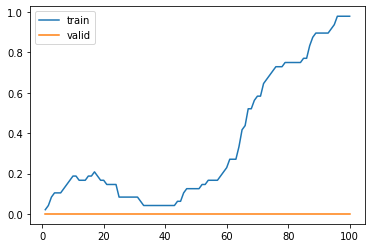

In [49]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

El sistema hizo un claro overfitting, lo cual es entendible por el tamaño del dataset y las pocas muestras de validación.

In [50]:
def one_hot_decode(encoded_seq, label_encoder):
    idx = [np.argmax(vector) for vector in encoded_seq]
    return label_encoder.inverse_transform(idx)

In [51]:
# Ensayo
x_test = [20, 25, 30]
y_test = [x+15 for x in x_test]

print("y_test:", y_test)

# Transformar los datos a oneHotEncoding
X1_test, X2_test, target_test, _ = get_dataset(np.array([x_test]), np.array([y_test]), label_encoder)

print("X1_test shape:", X1_test.shape)
print("X2_test shape:", X2_test.shape)
print("target_test shape:", target_test.shape)

y_test: [35, 40, 45]
Number of features/cardinality: 63
X1_test shape: (1, 3, 63)
X2_test shape: (1, 3, 63)
target_test shape: (1, 3, 63)


In [52]:
# Cuando quiera por ejemplo recuperar target_test a y_test utilizo:
one_hot_decode(target_test[0], label_encoder)

array([35, 40, 45])

In [53]:
cardinality = len(label_encoder.classes_)

# encode
# Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
# para enviar la primera vez al decoder
X1_test_tensor = torch.from_numpy(X1_test.astype(np.int32)).float()
prev_state = model.encoder(X1_test_tensor)

# start of sequence input --> la primera secuencia de salida-entrada (output_in)
# comienza en cero
target_seq = np.array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32)).float()
print("target_seq shape:", target_seq_tensor.shape)

# Vector de predicción
output = list()

for t in range(3):
    # Predicción del próximo elemento
    y_hat, new_prev_state = model.decoder(target_seq_tensor, prev_state)
    
    # Almacenar la predicción
    output.append(y_hat.detach().numpy()[0])
    
    # Actualizar los estados dado la ultimo prediccion
    prev_state = new_prev_state
    
    # Actualizar secuencia de entrada con la salida (re-alimentacion)
    target_seq_tensor = y_hat.unsqueeze(0)

print("y_test:", y_test)
print("y_hat:", one_hot_decode(output, label_encoder))

target_seq shape: torch.Size([1, 1, 63])
y_test: [35, 40, 45]
y_hat: [35 40 45]


### 4 - Conclusión
A primera vista parece muy compleja la estructura del encoder-decoder, pero funciona igual en cualquier disciplina de deeplearning:
- En visión para transferencia de estilo, generación de imagenes, etc.
- En NLP desde LSTM hasta Attention y transformes

Hay que pensar el encoder como el generador del "espacio latente". Luego el decoder necesita el espacio latente que representa a la setencia de entrada, la realimentación de los valores de salida del decoder y los estados internos de la LSTM para pasar a la siguiente inferencia hasta concluir la secuencia de salida.